<a href="https://colab.research.google.com/github/LiorProjects2024/Bird-vs.-Drone-Classification/blob/main/Bird_vs_Drone_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install split-folders

In [ ]:

import os
import time
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import splitfolders
from google.colab import drive
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# connecting all paths to the relvent folders
drive.mount('/content/drive')
input_folder = '/content/drive/My Drive/final_project/ver1'
output_folder = '/content/drive/My Drive/final_project/ver1_output'
if not os.path.exists(input_folder):
    raise FileNotFoundError(f"Input folder '{input_folder}' not found. Please check your path.")

# Deleting folders function to prevent problems
def reset_output_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    time.sleep(120) # Wait 2 minutes to ensure that the folders get fully deleted


# hyperparameters
epochs = 30
batch_size = 32
image_size = (224, 224)
all_accuracies = []
all_confusion_matrices = []
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

# Running the code 10 times so we will get an avrege of multiple runs as the data is small and the result can vary significantly by the split of the data
for seed in range(10):
    print(f"Running iteration {seed + 1}/10 with seed {seed}")

    reset_output_folder(output_folder)
 # splitting data into appropriate folders 70% training 20% validation 10% test
    import splitfolders
    splitfolders.ratio(input_folder, output=output_folder, seed=seed, ratio=(0.7, 0.2, 0.1))
    time.sleep(120)  # Wait 2 minutes to ensure that the images upload into the folders



# image augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        brightness_range=[0.8, 1.2],
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(output_folder, 'train'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=seed
    )
    validation_generator = test_val_datagen.flow_from_directory(
        os.path.join(output_folder, 'val'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    test_generator = test_val_datagen.flow_from_directory(
        os.path.join(output_folder, 'test'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    # Upload MobileNetV2 model without the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    #Leaving the rest of the weights of the other layers
    base_model.trainable = False

    #adding extra layers at the end
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.15),
        Dense(1, activation='sigmoid')
    ])
    #choosing an optimizer and its hyperparameters
    model.compile(optimizer=Adam(learning_rate=7e-5), loss='binary_crossentropy', metrics=['accuracy'])

    # training added layers
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)]
    )

    #Saving the data of each run
    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test accuracy for iteration {seed + 1}: {test_acc:.2f}")
    all_accuracies.append(test_acc)

    # saving confusion matrix data
    Y_pred = model.predict(test_generator)
    y_pred = np.round(Y_pred).astype(int)
    y_true = test_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    all_confusion_matrices.append(cm)


    reset_output_folder(output_folder)

Mounted at /content/drive
Running iteration 1/10 with seed 0


Copying files: 802 files [00:32, 24.62 files/s]


Found 559 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5967 - loss: 0.6707 - val_accuracy: 0.8188 - val_loss: 0.4728 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7393 - loss: 0.5250 - val_accuracy: 0.8875 - val_loss: 0.3892 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8652 - loss: 0.4102 - val_accuracy: 0.9000 - val_loss: 0.3300 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8565 - loss: 0.3630 - val_accuracy: 0.8938 - val_loss: 0.2926 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8678 - loss: 0.3412 - val_accuracy: 0.9062 - val_loss: 0.2709 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9085 - loss: 0.2907 - val_accuracy: 0.9125 - val_loss: 0.2473 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9249 - loss:

Copying files: 802 files [00:17, 45.41 files/s]


Found 560 images belonging to 2 classes.
Found 159 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.5133 - loss: 1.0775 - val_accuracy: 0.5786 - val_loss: 0.6967 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6190 - loss: 0.6575 - val_accuracy: 0.7107 - val_loss: 0.5641 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7069 - loss: 0.5367 - val_accuracy: 0.7736 - val_loss: 0.4899 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8443 - loss: 0.4193 - val_accuracy: 0.7925 - val_loss: 0.4415 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8470 - loss: 0.3711 - val_accuracy: 0.8176 - val_loss: 0.4020 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8517 - loss: 0.3469 - val_accuracy: 0.8239 - val_loss: 0.3739 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8750 - loss:

Copying files: 802 files [00:16, 48.32 files/s]


Found 559 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5656 - loss: 0.8032 - val_accuracy: 0.7063 - val_loss: 0.5661 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7170 - loss: 0.5544 - val_accuracy: 0.8250 - val_loss: 0.4545 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8148 - loss: 0.4482 - val_accuracy: 0.8375 - val_loss: 0.3902 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8708 - loss: 0.3618 - val_accuracy: 0.8625 - val_loss: 0.3454 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8887 - loss: 0.3510 - val_accuracy: 0.8750 - val_loss: 0.3199 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8845 - loss: 0.3231 - val_accuracy: 0.9000 - val_loss: 0.2915 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9144 - loss:

2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Deleted folder: /content/drive/My Drive/final_project/ver1_output
Running iteration 4/10 with seed 3


Copying files: 802 files [00:16, 48.74 files/s]


Found 560 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5686 - loss: 0.7417 - val_accuracy: 0.7188 - val_loss: 0.5986 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7094 - loss: 0.5809 - val_accuracy: 0.8188 - val_loss: 0.4544 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7520 - loss: 0.4805 - val_accuracy: 0.8875 - val_loss: 0.3693 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8276 - loss: 0.3979 - val_accuracy: 0.9187 - val_loss: 0.3211 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8819 - loss: 0.3248 - val_accuracy: 0.9312 - val_loss: 0.2849 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9100 - loss: 0.2792 - val_accuracy: 0.9375 - val_loss: 0.2563 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9113 - loss:

Copying files: 802 files [00:15, 50.17 files/s]


Found 560 images belonging to 2 classes.
Found 159 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5187 - loss: 0.8309 - val_accuracy: 0.7358 - val_loss: 0.5812 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6698 - loss: 0.5781 - val_accuracy: 0.8365 - val_loss: 0.4536 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8290 - loss: 0.4321 - val_accuracy: 0.8616 - val_loss: 0.3838 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8112 - loss: 0.4222 - val_accuracy: 0.8994 - val_loss: 0.3318 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8654 - loss: 0.3420 - val_accuracy: 0.9182 - val_loss: 0.2949 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8548 - loss: 0.3350 - val_accuracy: 0.9245 - val_loss: 0.2687 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8848 - loss:

Copying files: 802 files [00:16, 47.85 files/s]


Found 559 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5308 - loss: 0.7221 - val_accuracy: 0.7312 - val_loss: 0.5548 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7772 - loss: 0.5107 - val_accuracy: 0.8438 - val_loss: 0.4277 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8240 - loss: 0.4251 - val_accuracy: 0.8813 - val_loss: 0.3427 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8552 - loss: 0.3834 - val_accuracy: 0.9125 - val_loss: 0.2900 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8527 - loss: 0.3364 - val_accuracy: 0.9312 - val_loss: 0.2535 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9096 - loss: 0.2765 - val_accuracy: 0.9563 - val_loss: 0.2237 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8782 - loss:

Copying files: 802 files [00:17, 46.55 files/s]


Found 560 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5509 - loss: 0.7285 - val_accuracy: 0.7500 - val_loss: 0.5791 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7761 - loss: 0.4825 - val_accuracy: 0.8125 - val_loss: 0.4863 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8114 - loss: 0.4383 - val_accuracy: 0.8438 - val_loss: 0.4177 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8731 - loss: 0.3676 - val_accuracy: 0.8438 - val_loss: 0.3816 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8573 - loss: 0.3430 - val_accuracy: 0.8625 - val_loss: 0.3507 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8837 - loss: 0.2973 - val_accuracy: 0.8875 - val_loss: 0.3105 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8932 - loss:

Copying files: 802 files [00:17, 45.11 files/s]


Found 559 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4544 - loss: 0.8217 - val_accuracy: 0.7437 - val_loss: 0.5633 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7401 - loss: 0.5537 - val_accuracy: 0.8625 - val_loss: 0.4311 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8544 - loss: 0.4199 - val_accuracy: 0.9062 - val_loss: 0.3487 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8607 - loss: 0.3666 - val_accuracy: 0.9062 - val_loss: 0.3020 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8657 - loss: 0.3326 - val_accuracy: 0.9187 - val_loss: 0.2690 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8825 - loss: 0.2974 - val_accuracy: 0.9125 - val_loss: 0.2428 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9064 - loss:

Copying files: 802 files [00:17, 45.66 files/s]


Found 561 images belonging to 2 classes.
Found 159 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.4628 - loss: 0.8808 - val_accuracy: 0.6038 - val_loss: 0.6529 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6821 - loss: 0.5851 - val_accuracy: 0.7610 - val_loss: 0.5006 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8012 - loss: 0.4529 - val_accuracy: 0.8491 - val_loss: 0.4169 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8663 - loss: 0.3840 - val_accuracy: 0.8553 - val_loss: 0.3674 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8890 - loss: 0.3367 - val_accuracy: 0.8868 - val_loss: 0.3289 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8733 - loss: 0.3178 - val_accuracy: 0.8868 - val_loss: 0.2968 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8905 - loss:

Copying files: 802 files [00:17, 44.93 files/s]


Found 560 images belonging to 2 classes.
Found 159 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.4641 - loss: 0.8441 - val_accuracy: 0.6604 - val_loss: 0.5924 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6709 - loss: 0.5980 - val_accuracy: 0.8176 - val_loss: 0.4427 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7946 - loss: 0.4664 - val_accuracy: 0.8302 - val_loss: 0.3751 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8438 - loss: 0.3870 - val_accuracy: 0.8679 - val_loss: 0.3269 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8493 - loss: 0.3665 - val_accuracy: 0.8868 - val_loss: 0.2959 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8827 - loss: 0.3051 - val_accuracy: 0.9057 - val_loss: 0.2733 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9016 - loss:

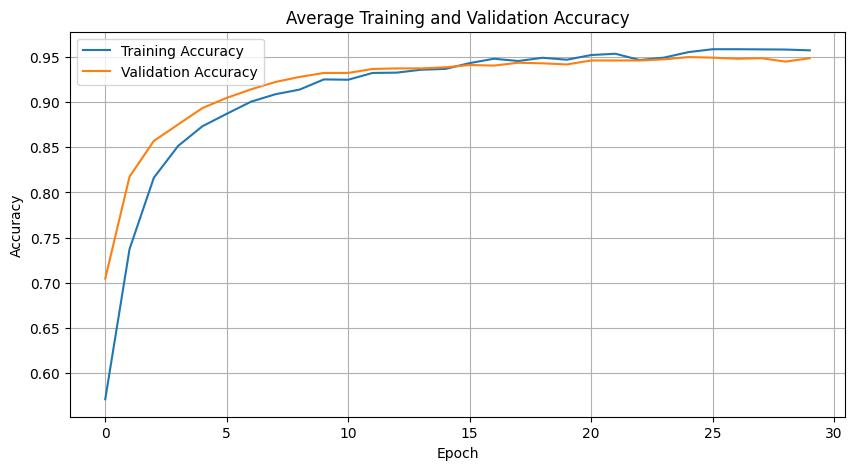

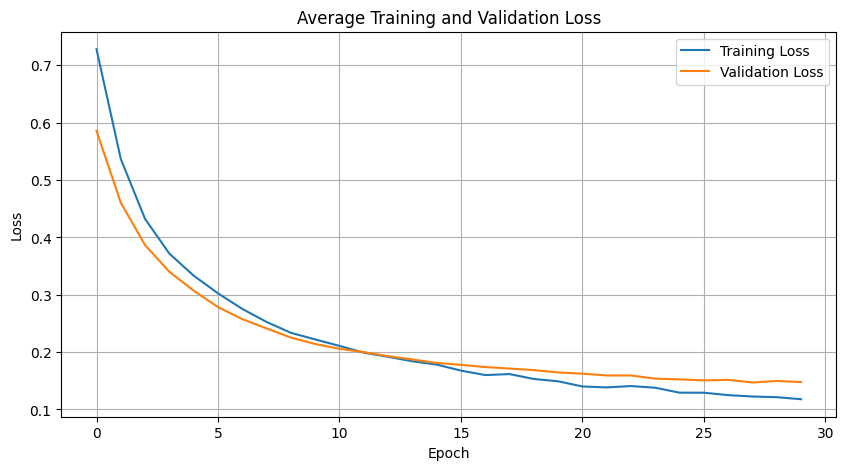

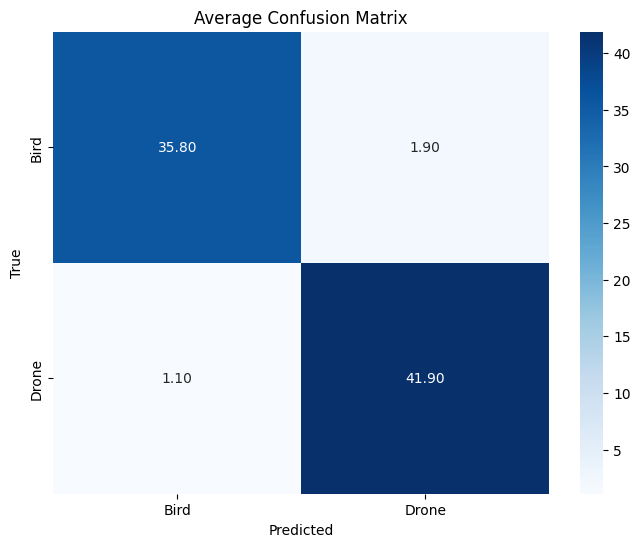

Average test accuracy across all runs: 0.96


In [ ]:
#Calculating averages creating graphs and confusion matrix
average_train_acc = np.mean(all_train_acc, axis=0)
average_val_acc = np.mean(all_val_acc, axis=0)
average_train_loss = np.mean(all_train_loss, axis=0)
average_val_loss = np.mean(all_val_loss, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(average_train_acc, label='Training Accuracy')
plt.plot(average_val_acc, label='Validation Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(average_train_loss, label='Training Loss')
plt.plot(average_val_loss, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


target_names = ['Bird', 'Drone']

average_cm = np.mean(all_confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

average_accuracy = np.mean(all_accuracies)
print(f"Average test accuracy across all runs: {average_accuracy:.2f}")
